In [9]:
import numpy as np
import matplotlib.pyplot as plt
from timeit import default_timer as timer
import seaborn as sns
from sklearn.metrics import confusion_matrix
from keras.models import Sequential
from keras.layers import Conv1D, Dropout, Dense
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.callbacks import LearningRateScheduler, ModelCheckpoint
from keras.utils import to_categorical

In [10]:
# Rutas de los conjuntos de datos
dataset_path = 'C:\\Users\\DAVID\\ML_pssp\\data\\cullpdb+profile_6133.npy'
cb513_path = 'C:\\Users\\DAVID\\ML_pssp\\data\\cb513+profile_split1.npy'

# Parámetros del modelo
sequence_len = 700
amino_acid_residues = 21
num_classes = 3  # Cambiado a 3
class_labels = ['H', 'E', 'C']  # Tres categorías principales
total_features = 57

In [11]:
# Función para mapear etiquetas a tres categorías
def map_to_three_classes(labels):
    # Mapear a las tres clases principales: H (Hélix), E (Hoja), C (Coil)
    three_class_labels = np.zeros_like(labels)
    # H (Helix) -> H (H)
    three_class_labels[:, :, 0] = labels[:, :, 2] + labels[:, :, 3] + labels[:, :, 4]
    # E (Sheet) -> E (E)
    three_class_labels[:, :, 1] = labels[:, :, 1] + labels[:, :, 5]
    # C (Coil) -> C (C)
    three_class_labels[:, :, 2] = labels[:, :, 0] + labels[:, :, 6] + labels[:, :, 7]
    return three_class_labels

In [12]:
# Función para cargar el conjunto de datos
def get_dataset(path):
    ds = np.load(path)
    ds = np.reshape(ds, (ds.shape[0], sequence_len, total_features))
    ret = np.zeros((ds.shape[0], ds.shape[1], amino_acid_residues + 8))
    ret[:, :, 0:amino_acid_residues] = ds[:, :, 35:56]
    ret[:, :, amino_acid_residues:] = ds[:, :, amino_acid_residues + 1:amino_acid_residues + 1 + 8]
    ret[:, :, amino_acid_residues:] = map_to_three_classes(ret[:, :, amino_acid_residues:])  # Mapear etiquetas
    return ret

def split_with_shuffle(Dataset, seed=None):
    np.random.seed(seed)
    np.random.shuffle(Dataset)
    train_split = int(Dataset.shape[0] * 0.8)
    test_val_split = int(Dataset.shape[0] * 0.1)
    Train = Dataset[0:train_split, :, :]
    Test = Dataset[train_split:train_split + test_val_split, :, :]
    Validation = Dataset[train_split + test_val_split:, :, :]
    return Train, Test, Validation

# Función para dividir el conjunto de datos como en el paper
def split_like_paper(dataset):
    Train = dataset[:5600]
    Test = dataset[5600:5877]
    Validation = dataset[5877:]
    return Train, Test, Validation

# Función para obtener los datos y las etiquetas
def get_data_labels(dataset):
    X = dataset[:, :, :amino_acid_residues]
    Y = dataset[:, :, amino_acid_residues:amino_acid_residues + num_classes]
    return X, Y

In [13]:
# Función para crear el modelo CNN
def CNN_model():
    model = Sequential([
        Conv1D(128, 7, padding='same', activation='relu', input_shape=(sequence_len, amino_acid_residues), kernel_regularizer=l2(0.001)),
        Dropout(0.4),
        Conv1D(64, 5, padding='same', activation='relu', kernel_regularizer=l2(0.001)),
        Dropout(0.4),
        Conv1D(num_classes, 3, padding='same', activation='softmax')
    ])
    model.compile(optimizer=Adam(learning_rate=0.00005),
                  loss='categorical_crossentropy',
                  metrics=['accuracy', 'mae'])
    model.summary()
    return model

In [14]:
# Cargar los datos
dataset = get_dataset(dataset_path)
CB513_X, CB513_Y = get_data_labels(get_dataset(cb513_path))

# Dividir los datos
D_train, D_test, D_val = split_like_paper(dataset)
# D_train, D_test, D_val = split_with_shuffle(dataset, 100)
X_train, Y_train = get_data_labels(D_train)
X_test, Y_test = get_data_labels(D_test)
X_val, Y_val = get_data_labels(D_val)

C:\Users\DAVID\AppData\Local\Temp\ipykernel_15196\2249023693.py:3: UserWarning: Reading `.npy` or `.npz` file required additional header parsing as it was created on Python 2. Save the file again to speed up loading and avoid this warning.
  ds = np.load(path)


In [15]:
# Función para calcular la precisión Q3
def Q3_accuracy(real, pred):
    mask = np.sum(real, axis=-1) > 0
    correct = np.sum((np.argmax(real, axis=-1) == np.argmax(pred, axis=-1)) & mask)
    total = np.sum(mask)
    return correct / total

In [16]:
# Crear el modelo CNN
net = CNN_model()

# Callbacks
lr_scheduler = LearningRateScheduler(lambda epoch: 0.00005 * (0.1 ** (epoch // 10)))
filepath = "C:\\Users\\DAVID\\ML_pssp\\results\\Whole_CullPDB_Q3-best.keras"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [lr_scheduler, checkpoint]

# Entrenar el modelo
history = net.fit(X_train, Y_train, epochs=20, batch_size=128, shuffle=True,
                  validation_data=(X_val, Y_val), callbacks=callbacks_list)

# Evaluar el modelo en los datos de prueba y CB513
test_accuracy = Q3_accuracy(Y_test, net.predict(X_test))
cb513_accuracy = Q3_accuracy(CB513_Y, net.predict(CB513_X))
print("\n\nQ3 accuracy on Test Dataset: {:.4f}".format(test_accuracy))
print("Q3 accuracy on CB513 Dataset: {:.4f}\n\n".format(cb513_accuracy))

Epoch 1/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3750 - loss: 0.4405 - mae: 0.3639
Epoch 1: val_accuracy improved from -inf to 0.14866, saving model to C:\Users\DAVID\ML_pssp\results\Whole_CullPDB_Q3-best.keras
44/44 ━━━━━━━━━━━━━━━━━━━━ 79s 2s/step - accuracy: 0.3744 - loss: 0.4406 - mae: 0.3639 - val_accuracy: 0.1487 - val_loss: 0.4240 - val_mae: 0.3616 - learning_rate: 5.0000e-05
Epoch 2/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 892ms/step - accuracy: 0.3718 - loss: 0.4269 - mae: 0.3611
Epoch 2: val_accuracy improved from 0.14866 to 0.17379, saving model to C:\Users\DAVID\ML_pssp\results\Whole_CullPDB_Q3-best.keras
44/44 ━━━━━━━━━━━━━━━━━━━━ 41s 906ms/step - accuracy: 0.3725 - loss: 0.4269 - mae: 0.3611 - val_accuracy: 0.1738 - val_loss: 0.4023 - val_mae: 0.3569 - learning_rate: 5.0000e-05
Epoch 3/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 938ms/step - accuracy: 0.5175 - loss: 0.4106 - mae: 0.3565
Epoch 3: val_accuracy improved from 0.17379 to 0.88900, saving model to C:\Users\DAVID\ML_p

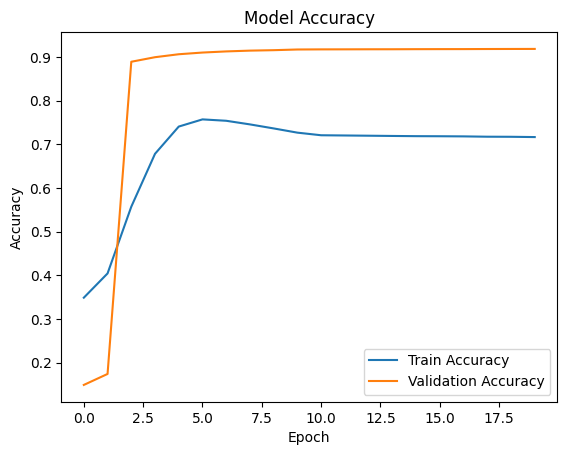

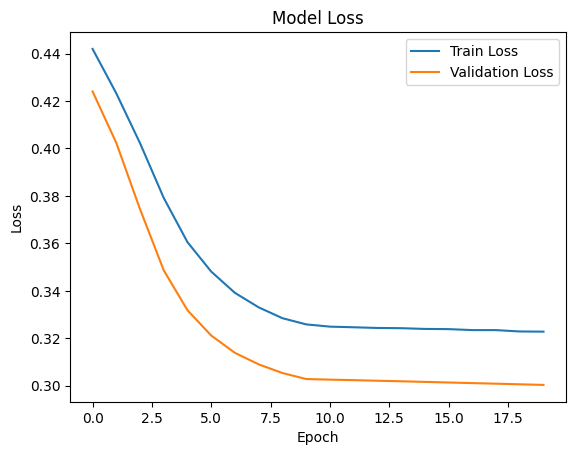

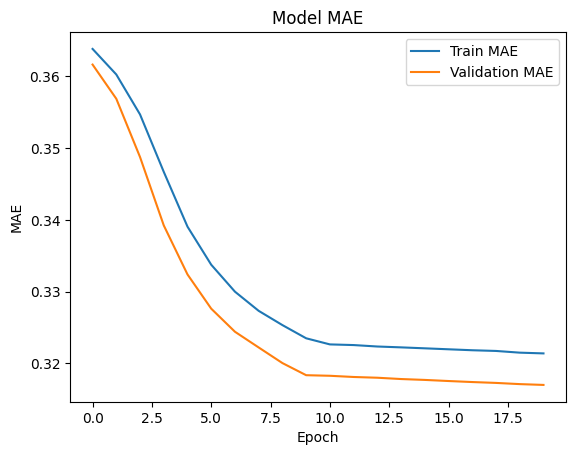

In [17]:
# Graficar historias de entrenamiento
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Model MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.show()

In [18]:
def plot_confusion_matrix(y_true, y_pred, classes):
    y_true_labels = np.argmax(y_true, axis=-1).flatten()
    y_pred_labels = np.argmax(y_pred, axis=-1).flatten()
    
    # Filtrar etiquetas válidas
    valid_idx = y_true_labels != 8  # Aquí 8 es la etiqueta de padding, ajustar según el caso
    y_true_labels = y_true_labels[valid_idx]
    y_pred_labels = y_pred_labels[valid_idx]

    cm = confusion_matrix(y_true_labels, y_pred_labels)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


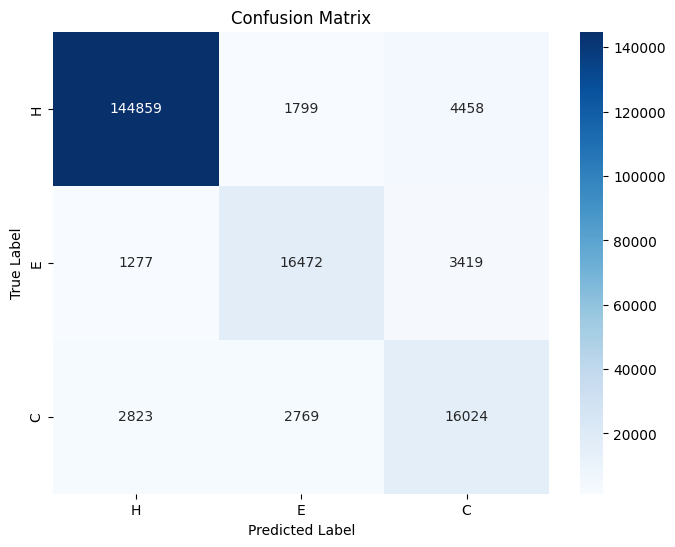

In [19]:
plot_confusion_matrix(Y_test, net.predict(X_test), classes=class_labels)

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


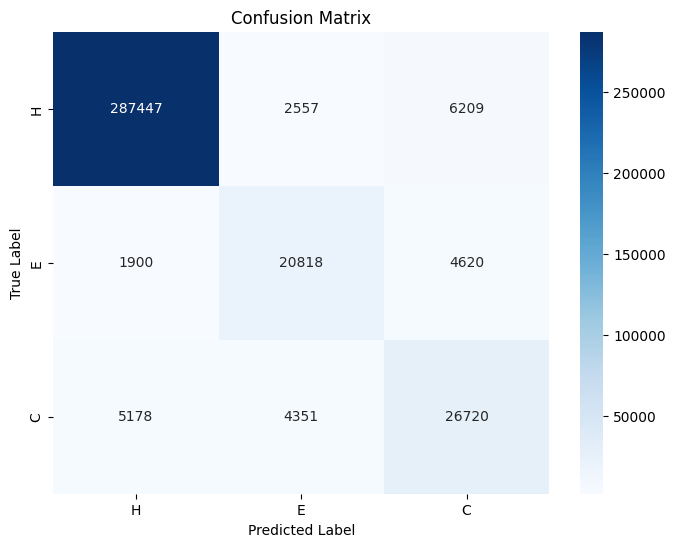

In [20]:
plot_confusion_matrix(CB513_Y, net.predict(CB513_X), classes=class_labels)

In [21]:
#net.save('C:\\Users\\DAVID\\ML_pssp\\model\\Whole_CullPDB_Q3_CB513_0.70.keras')